### Setup ambiente e importações de módulos

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import logging
import os
import cx_Oracle
#logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
#from ads.dataset.factory import DatasetFactory
#from sqlalchemy import create_engine
# Add TNS_ADMIN to the environment
os.environ['TNS_ADMIN'] = "/home/datascience/ADB"
connection = cx_Oracle.connect('hackathon', 'bCfrCC0981267', 'adw_low')

In [2]:
pd.options.display.float_format = 'R${:,.2f}'.format

# Valor total de transações versus transações no cartão carrefour em postos Carrefour

In [3]:
BUFFER_CCI = pd.read_sql("Select sum(ICUP_VL_PAGOCARTAO) Cartao,  sum(ICUP_VL_TOTALITEM) Total, (sum(ICUP_VL_PAGOCARTAO)/sum(ICUP_VL_TOTALITEM)) PCT_SHARE  FROM EVE_BUFFER_CCI_AQUISICAO_HCKT WHERE ICUP_DT_CUPOM BETWEEN TO_DATE('01/01/2020' , 'DD/MM/YYYY') AND  TO_DATE('31/01/2020' , 'DD/MM/YYYY') and MERC_DS_TIPO_ESTABELECIMENTO='5-POSTO'",  con=connection) 
BUFFER_CCI.style.format({'CARTAO': 'R${:,.2f}','TOTAL': 'R${:,.2f}','PCT_SHARE':"{:.2%}"})
#BUFFER_CCI

,CARTAO,TOTAL,PCT_SHARE
0,"R$1,287,056.68","R$4,156,446.34",30.97%


# Evolução do share do cartão em 2020

In [4]:
BUFFER_CCI_MENSAL = pd.read_sql("Select to_char(ICUP_DT_CUPOM,'mm/yyyy') Mes, sum(ICUP_VL_PAGOCARTAO) Cartao,  sum(ICUP_VL_TOTALITEM) Total, (sum(ICUP_VL_PAGOCARTAO)/sum(ICUP_VL_TOTALITEM)) PCT_SHARE  FROM EVE_BUFFER_CCI_AQUISICAO_HCKT where ICUP_DT_CUPOM >= to_date('01/01/2020','dd/mm/yyyy') and MERC_DS_TIPO_ESTABELECIMENTO='5-POSTO' group by to_char(ICUP_DT_CUPOM,'mm/yyyy')  order by 1",  con=connection) 
BUFFER_CCI_MENSAL.style.format({'MES': '','CARTAO': 'R${:,.2f}','TOTAL': 'R${:,.2f}','PCT_SHARE':"{:.2%}"})
#BUFFER_CCI_MENSAL.plot(x='MES',y='PCT_SHARE')
#BUFFER_CCI_MENSAL


,MES,CARTAO,TOTAL,PCT_SHARE
0,,"R$1,287,056.68","R$4,156,446.34",30.97%
1,,"R$1,469,553.88","R$4,147,390.12",35.43%
2,,"R$338,505.77","R$1,827,998.62",18.52%
3,,"R$739,815.16","R$1,942,840.31",38.08%
4,,"R$789,019.51","R$2,119,451.98",37.23%
5,,"R$962,512.69","R$2,460,125.60",39.12%
6,,"R$1,175,860.49","R$2,936,609.45",40.04%
7,,"R$758,130.95","R$1,864,505.26",40.66%
8,,"R$521,065.16","R$1,281,785.20",40.65%


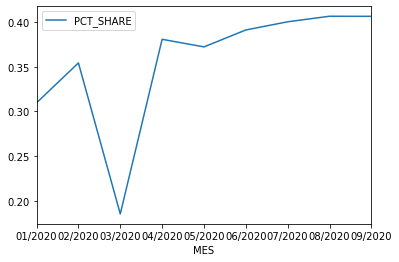

In [5]:
BUFFER_CCI_MENSAL.plot(x='MES',y='PCT_SHARE')

# Qual o volume de transações que representa um incremento de 5% no nosso share de pagamentos nos postos do Grupo ?

In [6]:
print('Faturamento médio postos:')
print("R${:,.2f}".format(BUFFER_CCI_MENSAL['TOTAL'].mean()))
X = (BUFFER_CCI_MENSAL['TOTAL'].mean())*0.05
print('Incremento de receita mensal:')
print("R${:,.2f}".format(X))
print('Incremento de receita no ano:')
print("R${:,.2f}".format(X*12))



Faturamento médio postos:
R$2,526,350.32
Incremento de receita mensal:
R$126,317.52
Incremento de receita no ano:
R$1,515,810.19


# Vamos estimar quantos clientes novos utilizando a tag precisamos para atingir essa receita, para isso vamos entender o ticket médio do posto

In [7]:
TICKET_MEDIO = pd.read_sql("SELECT COUNT(DISTINCT CUP_ID_CUPOM) QTD_CUPONS, SUM(ICUP_VL_TOTALITEM)  VALOR_CUPOM , SUM(ICUP_VL_TOTALITEM)/COUNT(DISTINCT CUP_ID_CUPOM) TICKET_MEDIO FROM EVE_BUFFER_CCI_AQUISICAO_HCKT where MERC_DS_TIPO_ESTABELECIMENTO='5-POSTO' AND ICUP_DT_CUPOM >= to_date('01/01/2020','dd/mm/yyyy')", con=connection) 
TICKET_MEDIO

,QTD_CUPONS,VALOR_CUPOM,TICKET_MEDIO
0,258012,"R$22,737,152.88",R$88.12


In [8]:
TM = TICKET_MEDIO['TICKET_MEDIO'].sum()
QTD_CLIENTES = X/TM
print("{:,.2f}".format(QTD_CLIENTES))

1,433.40


# Faturamento total ONUS (9 meses)

In [9]:
FATURAMENTO_TOTAL_ONUS = pd.read_sql("Select sum(ICUP_VL_PAGOCARTAO) FATURAMENTO_ONUS FROM EVE_BUFFER_CCI_AQUISICAO_HCKT WHERE ICUP_DT_CUPOM >= TO_DATE('01/01/2020' , 'DD/MM/YYYY')",  con=connection) 
FATURAMENTO_TOTAL_ONUS.style.format({'FATURAMENTO_ONUS': 'R${:,.2f}' })
#BUFFER_CCI
print("{:.2%}".format((X*9)/FATURAMENTO_TOTAL_ONUS['FATURAMENTO_ONUS'].sum()))

0.72%


# Precisamos de 1.400 clientes transacionando mensalmente em postos através da tag para alcançar os 5% de incremento no share de meios de pagamento. Isso representa um incremento de R$1.5 M no faturamento anual ou seja 0,72% do faturamento total ON-US

In [10]:
total_mensalidade = 1433.40 * 12 * 5
print('Valor faturamento anual considerando uma mensalidade de 5 reais pelo serviço')
print("R${:,.2f}".format(total_mensalidade))


Valor faturamento anual considerando uma mensalidade de 5 reais pelo serviço
R$86,004.00


<font color='red' size='big'> OBS. Os valores são baseados na amostra de dados disponibilizada para o Hackaton, os números podem apresentam volume maior se utilizada a base inteira para análise</font>